In [1]:
# Imports
import sys ; sys.path.append('../')
import torch.optim as optim
import torch
import seaborn as sb
import pytorch_lightning as pl
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import time

from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from learn_KKL.system import RevDuffing
from learn_KKL.luenberger_observerV3 import LuenbergerObserver
from learn_KKL.learnerV3 import Learner
from learn_KKL.raffinement_dimN import *
import matplotlib.pyplot as plt

In [2]:
"Objective : test the refinement tools for RevDuffing system. The test is in 3 steps :"
"-train and predict over an initial uniform grid. The obtained error is used as the refinement criterium."
"-refine 2 new grids from the orignial one, the first one refined with the prediction error over x1, the second over x2."
"-train and predict with the refinde grids. The first one to train for x1, the second one for x2."
"-compare RMSE with uniform grids of same size."
# Set up the system
system = RevDuffing()
# Instantiate the observer
"separation=True means that each xi can be learned separately"
observer = LuenbergerObserver(dim_x=2, dim_y=1, separation=True, method='Supervised', recon_lambda=0.8, wc=0.03,
                              num_hl=5, size_hl=50,
                              activation=torch.nn.SiLU())
observer.set_dynamics(system)
# Generate initial dataset
"generate_data_svl returns data tensor in shape [num_samples,dimx+dimz] and grid, which is the collection of cells if method=adaptative. Else grid=0"
"if method=adaptative, num_samples is no int but list of int (here [30,30]), meaning a grid of size 30*30"
"for uniform and LHS method, you can set num_sample as integer"
data,grid = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [30,30],
                                  method='adaptative')

In [3]:
# Generate the test dataset
data_test,grid_test = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [80,80],
                                  method='adaptative')

In [3]:
data_init, val_data_init = train_test_split(data, test_size=0.3, shuffle=True)
data_init.shape

torch.Size([630, 5])

In [4]:
# Train and predict x1
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
"separation=True means that only x[axe] will be learned"
learner_T_star = Learner(observer=observer, system=system, training_data=data_init,
                         validation_data=val_data_init,
                         separation=True, axe=0,
                         method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger1,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

# predict x1_hat
x1 = data[:,0]
x1 = torch.as_tensor(x1)
z = data[:,2:5]
z = torch.as_tensor(z)

x1_hat = observer.decoder(z).detach()
print(x1_hat.shape)
error1 = torch.abs(x1-x1_hat[:,0])
rmse = torch.sqrt((error1**2).sum())
print("RMSE : ",rmse)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_73/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.0 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_73


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the nu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 5.0000e-05.
torch.Size([900, 1])
RMSE :  tensor(5.9783)


In [5]:
# Train and predict x2
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
"separation=True means that only x[axe] will be learned"
learner_T_star = Learner(observer=observer, system=system, training_data=data_init,
                         validation_data=val_data_init,
                         separation=True, axe=1,
                         method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger1,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

# predict x2_hat
x2 = data[:,1]
x2 = torch.as_tensor(x2)
z = data[:,2:5]
z = torch.as_tensor(z)

x2_hat = observer.decoder(z).detach()
print(x2_hat.shape)
error2 = torch.abs(x2-x2_hat[:,0])
rmse = torch.sqrt((error2**2).sum())
print("RMSE : ",rmse)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_74/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.0 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_74


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 5.0000e-05.
torch.Size([900, 1])
RMSE :  tensor(0.7445)


[tensor(5.9783), tensor(0.7445)]


C:\Users\pchauris\AppData\Local\Temp\ipykernel_12800\552944974.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(p1,ax=ax1)
C:\Users\pchauris\AppData\Local\Temp\ipykernel_12800\552944974.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(p2,ax=ax2)


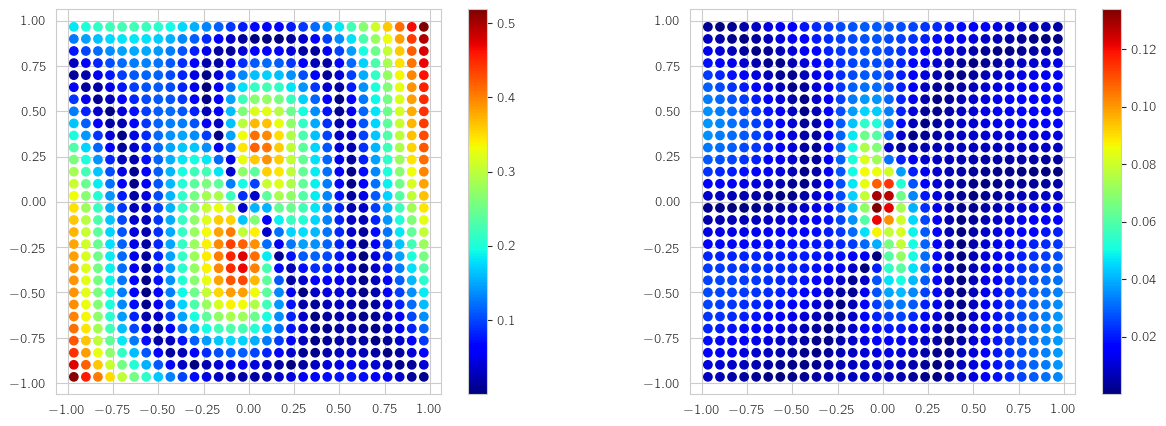

In [6]:
# Display errors
print([torch.sqrt((error1 ** 2).sum()),torch.sqrt((error2 ** 2).sum())])
im,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
p1 = ax1.scatter(x1,x2,c=error1,cmap='jet')
ax1.axis('square')
im.colorbar(p1,ax=ax1)
p2 = ax2.scatter(x1,x2,c=error2,cmap='jet')
ax2.axis('square')
im.colorbar(p2,ax=ax2)
plt.show()

In [49]:
# refine the initial dataset with the criteria
"grid is list of cells"
"critere is 1D array of size equal to the number of cells in the grid"
critere1 = error1
critere2 = error2
data1,grid1 = observer.raffine_grid(grid,critere1)
data2,grid2 = observer.raffine_grid(grid,critere2)

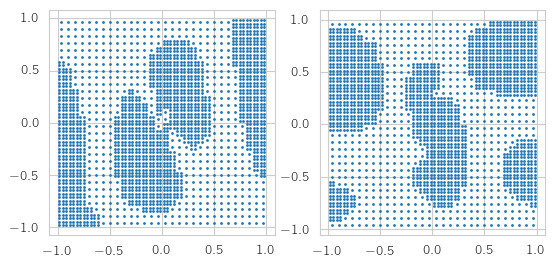

In [50]:
_,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(coordinate(grid1)[:,0],coordinate(grid1)[:,1],s=1)
ax2.scatter(coordinate(grid2)[:,0],coordinate(grid2)[:,1],s=1)
ax1.axis('square')
ax2.axis('square')
plt.show()

In [51]:
data_1, val_data_1 = train_test_split(data1, test_size=0.3, shuffle=True)
data_2, val_data_2 = train_test_split(data2, test_size=0.3, shuffle=True)

In [62]:
# Train and predict x1 with the refined grid grid1
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
"separation=True means that only x[axe] will be learned"
learner_T_star = Learner(observer=observer, system=system, training_data=data_1,
                         validation_data=val_data_1,
                         separation=True, axe=0,
                         method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger1,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

#predict x1
x1 = data_test[:,0]
x1 = torch.as_tensor(x1)
z = data_test[:,2:5]
z = torch.as_tensor(z)

x1_hat = observer.decoder(z).detach()
error1 = torch.abs(x1-x1_hat[:,0])
rmse = torch.sqrt((error1**2).sum())
print("RMSE : ",rmse)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_67/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.0 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_67


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RMSE :  tensor(12.0682)


In [63]:
# Train and predict x2 with the refined grid grid2
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
"separation=True means that only x[axe] will be learned"
learner_T_star = Learner(observer=observer, system=system, training_data=data_2,
                         validation_data=val_data_2,
                         separation=True, axe=1,
                         method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger1,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

#predict x2
x2 = data_test[:,1]
x2 = torch.as_tensor(x2)
z = data_test[:,2:5]
z = torch.as_tensor(z)

x2_hat = observer.decoder(z).detach()
error2 = torch.abs(x2 - x2_hat[:, 0])
rmse = torch.sqrt((error2 ** 2).sum())
print("RMSE : ", rmse)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_68/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.0 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_68


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 5.0000e-05.
RMSE :  tensor(1.4825)


[tensor(12.0682), tensor(1.4825)]


C:\Users\pchauris\AppData\Local\Temp\ipykernel_13148\552944974.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(p1,ax=ax1)
C:\Users\pchauris\AppData\Local\Temp\ipykernel_13148\552944974.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(p2,ax=ax2)


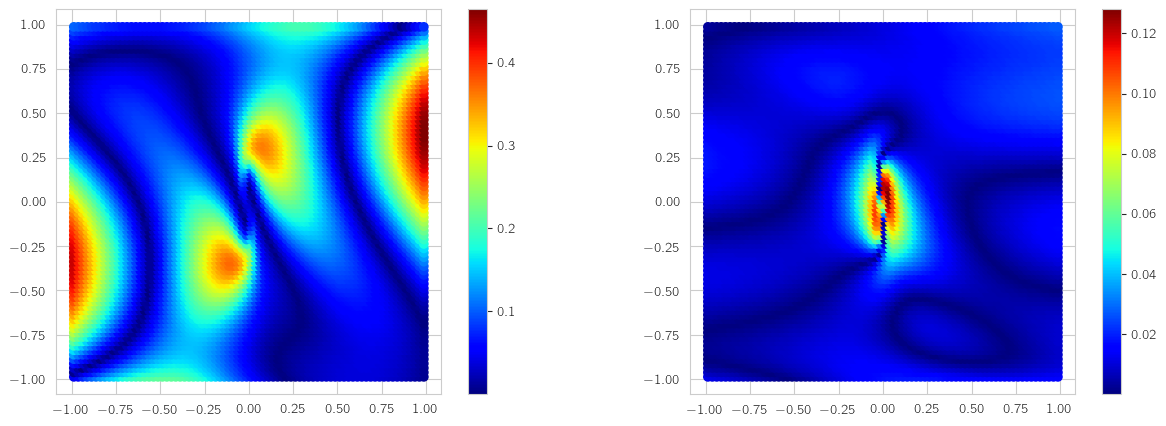

In [64]:
# Display errors
print([torch.sqrt((error1 ** 2).sum()),torch.sqrt((error2 ** 2).sum())])
im,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
p1 = ax1.scatter(x1,x2,c=error1,cmap='jet')
ax1.axis('square')
im.colorbar(p1,ax=ax1)
p2 = ax2.scatter(x1,x2,c=error2,cmap='jet')
ax2.axis('square')
im.colorbar(p2,ax=ax2)
plt.show()

In [57]:
# Training uniform dataset with equal number of points
data_uni1,_ = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [len(grid1),1],
                                  method='uniform')
data_uni2,_ = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [len(grid2),1],
                                  method='uniform')
print(data_uni1.shape)
print(data_uni2.shape)

Computed the smallest possible uniform grid for the given dimensions, then deleted 22 samples randomly to match the desired number of samples 2094.
Computed the smallest possible uniform grid for the given dimensions, then deleted 37 samples randomly to match the desired number of samples 2079.
torch.Size([2094, 5])
torch.Size([2079, 5])


In [58]:
data_uni_x1, val_data_uni1 = train_test_split(data_uni1, test_size=0.3, shuffle=True)
data_uni_x2, val_data_uni2 = train_test_split(data_uni2, test_size=0.3, shuffle=True)

In [65]:
# Train and predict x1 with the uniform grid 1
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
"separation=True means that only x[axe] will be learned"
learner_T_star = Learner(observer=observer, system=system, training_data=data_uni_x1,
                         validation_data=val_data_uni1,
                         separation=True, axe=0,
                         method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger1,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

#predict x1
x1 = data_test[:,0]
x1 = torch.as_tensor(x1)
z = data_test[:,2:5]
z = torch.as_tensor(z)

x1_hat = observer.decoder(z).detach()
error1 = torch.abs(x1-x1_hat[:,0])
rmse = torch.sqrt((error1**2).sum())
print("RMSE : ",rmse)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_69/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.0 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_69


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 5.0000e-05.


Validation: 0it [00:00, ?it/s]

RMSE :  tensor(10.0539)


In [66]:
# Train and predict x2 with the uniform grid 2
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
"separation=True means that only x[axe] will be learned"
learner_T_star = Learner(observer=observer, system=system, training_data=data_uni_x2,
                         validation_data=val_data_uni2,
                         separation=True, axe=1,
                         method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger1,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

#predict x2
x2 = data_test[:,1]
x2 = torch.as_tensor(x2)
z = data_test[:,2:5]
z = torch.as_tensor(z)

x2_hat = observer.decoder(z).detach()
error2 = torch.abs(x2 - x2_hat[:, 0])
rmse = torch.sqrt((error2 ** 2).sum())
print("RMSE : ", rmse)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_70/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.0 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_70


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RMSE :  tensor(1.4527)


[tensor(10.0539), tensor(1.4527)]


C:\Users\pchauris\AppData\Local\Temp\ipykernel_13148\520913191.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(p1,ax=ax1)
C:\Users\pchauris\AppData\Local\Temp\ipykernel_13148\520913191.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(p2,ax=ax2)


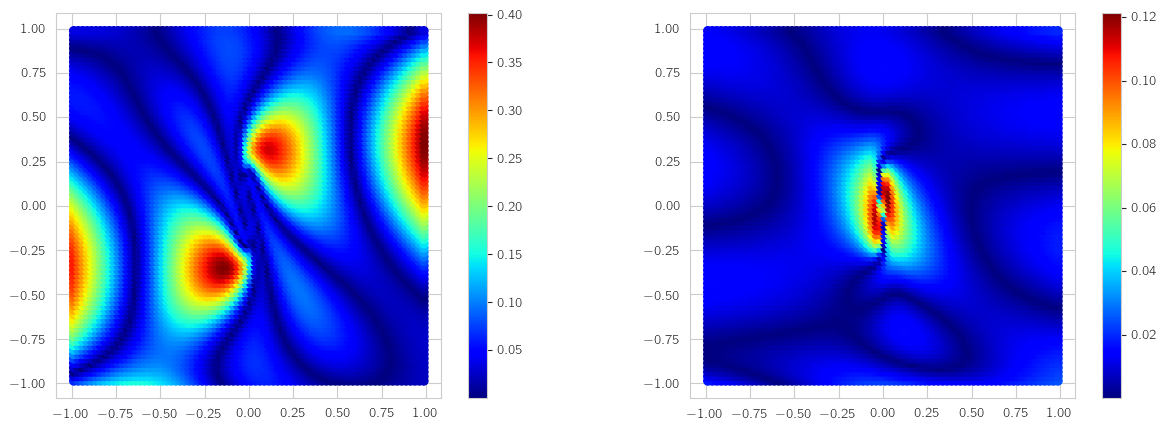

In [67]:
# Display errors
print([torch.sqrt((error1 ** 2).sum()),torch.sqrt((error2 ** 2).sum())])
im,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
p1 = ax1.scatter(x1,x2,c=error1,cmap='jet')
ax1.axis('square')
im.colorbar(p1,ax=ax1)
p2 = ax2.scatter(x1,x2,c=error2,cmap='jet')
ax2.axis('square')
im.colorbar(p2,ax=ax2)
plt.show()